
```
Title: Facial Expression Recognition
Author Name: Bisar Ul Hasan
Author Kaggle UserName: iambisar
Student ID: 46335706
```




# Introduction
This notebook is for the major project submission for COMP8220, on the Facial Image dataset and the task of this project is to use conventional ML models and deep learning models to classify each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). Main objective of the project is to experiment and implement the approaches we've learnt to build a high-performing system and compare the results of each approach.
***
# About Datasets
We are using a Subset of [FER 2013](https://www.kaggle.com/datasets/msambare/fer2013) Dataset which in actual conists of 32298 Samples. **The subset consists of 9328 Samples**. We will be further splitting this subset into 80% training and 20% testing splits. So, we will be training all the models on just 7426 samples. Public and private datasets are more likely acting as validation sets in this scenario and we are fetching the test set from training set.

- Training Set Sample Size: 7462 
- Testing Set Sample Size: 1866
- Public Test Set: 1136
- Private Test Set: 1153
***
The Notebook contains the following sections:

1. Basic Setup
  1. Importing Necessary Libraries
  2. Loading & Preparing Datasets
  3. Performing data analysis
2. Conventional ML Models
  1. Data Preprocessing 
  2. Data Splitting & Feature Scaling
  3. Conv Model Training: Main Dataset
      1. Model 1: Linear SVC
      2. Model 2: Random Forest Classifier
      3. Model 3: Linear Gradient Bossting Machine(LGBM)
      4. Predictions using Selected model(LGBM)
        1. Prediction on Facial Expression Recognition: PUBLIC TEST
        2. Prediction on Facial Expression Recognition: PRIVATE TEST
  4. Conv Model Training: Out-of-Domain Dataset
      1. OOD Data Preprocessing
      2. Splitting Combined Dataset
      3. Fitting Selected Model(LGBM) on Combined Dataset
      4. Predictions on OOD using Selected model(LGBM)
        1. Prediction on Facial Expression Recognition (OOD): PUBLIC TEST
        2. Prediction on Facial Expression Recognition (OOD): Priavte TEST
  5. Notes on the Conventional ML Model

3. Deep Learning Models
  1. Data Preprocessing & Data Splitting
  2. Model Training
      1. Model 1: Basic Convolutional Neural Network
      2. Random Search (Training CNN on Different Combination of Layers and Parameters)
      3. Model 2: Selecting more complicated Conv2D Architecture (6 Layer)
      4. Predictions using Selected Model(Model 2: 6 Layer)
        1. Prediction on Facial Expression Recognition: PUBLIC Test
        2. Prediction on Facial Expression Recognition: PRIVATE Test
  3. Deep Learning Models (CNN): Out-of-Domain Dataset
      1. OOD Data Preprocessing
      2. Fitting Selected Model(LGBM) on MNIST
        1. Prediction on Facial Expression Recognition (OOD): PUBLIC TEST
        2. Prediction on Facial Expression Recognition (OOD): Priavte TEST
  4. Notes on Deep Learning Model
4. Discussion of the performance of the two models & Conclusion.

# 1 Basic Setup

## 1.1 Importing Necessary Libraries

In [50]:
#Connecting to google drive
from google.colab import drive

#Importing Data Processing & Model Evaluation Libraries
from os.path import join

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


#Importing Necessary libraries for Conventional ML Models
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb


#Importing Necessary libraries for Deep Learning Models
import keras
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

## 1.2 Loading and Preparing Datasets

In [29]:
#Please Note: Variables named as Images refer to features and variables named as labels refer to target(emotions) variables.
#Establishing connection with Google Drive for accessing required datasets
drive.mount('/content/drive/')

image_size = 48
EMOTIONS = ['angry', 'disgusted', 'fearful','happy', 'sad', 'surprised', 'neutral', 'OTHER'] #Creating a list of labels to map numerical emotion label to categorical value

dataset_directory = '/content/drive/MyDrive/Machine Learning/Major Project/Data'  #Setting up Current working directory of google drive for accessing
output_directory = '/content/drive/MyDrive/Machine Learning/Major Project/Predictions'#storing files

#Loading Dataset of human faces(Training features + Training Outcome variables)
images_train = np.load(join(dataset_directory, 'Training_data_images.npy'))
labels_train = np.load(join(dataset_directory, 'Training_data_labels.npy'))

#Loading Dataset of human faces(Public & Private Testing features)
images_test_public = np.load(join(dataset_directory, 'PublicTest_faces_only_data_images.npy'))
images_test_private = np.load(join(dataset_directory, 'PrivateTest_data_images.npy'))


#Reshapping Features
images_train = images_train.reshape([-1, image_size, image_size])
images_test_public = images_test_public.reshape([-1, image_size, image_size])
images_test_private = images_test_private.reshape([-1, image_size, image_size])

print("Shape of features of images from training set: ", images_train.shape)
print("Shape of labels from training set: ",labels_train.shape)
print("features from public test set: ", images_test_public.shape)
print("features from private test set: ", images_test_private.shape)

Shape of features of images from training set:  (9328, 48, 48)
Shape of labels from training set:  (9328,)
features from public test set:  (1136, 48, 48)
features from private test set:  (1153, 48, 48)


## 1.3 Performing Data Analysis

In [30]:
#Looking at all the classes in our dataset
list_of_emotions = list(labels_train)
np.unique(list_of_emotions)

array([0, 1, 2, 3, 4, 5, 6])

In [31]:
sample = 0
print(images_train[sample])
print(labels_train[sample])
print(EMOTIONS[labels_train[sample]])

[[0.25098039 0.24705882 0.2745098  ... 0.16078431 0.2        0.21960784]
 [0.22745098 0.19215686 0.20784314 ... 0.14509804 0.16470588 0.18823529]
 [0.12941176 0.14901961 0.16862745 ... 0.17254902 0.21568627 0.20784314]
 ...
 [0.14117647 0.19215686 0.23137255 ... 0.19607843 0.22352941 0.25882353]
 [0.12156863 0.12941176 0.18431373 ... 0.2627451  0.26666667 0.23137255]
 [0.14901961 0.09019608 0.09803922 ... 0.37254902 0.26666667 0.21568627]]
0
angry


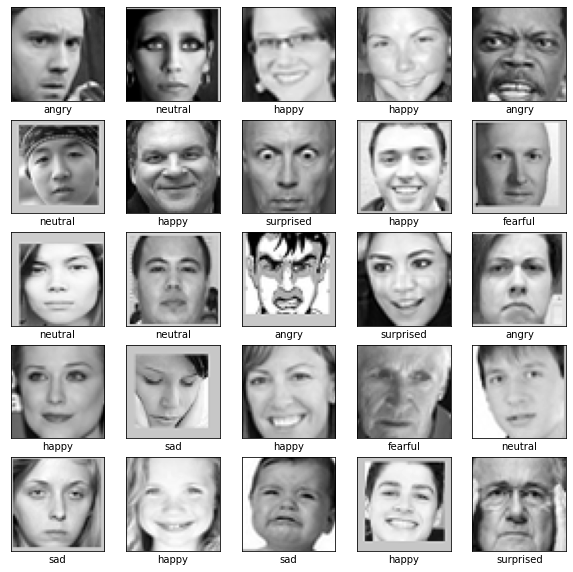

In [32]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train[i], cmap='gray')
    plt.xlabel( EMOTIONS[ labels_train[i] ] )
plt.show()

In [33]:
#Checking the distribution with respect to emotions
emotions = pd.Series(labels_train)
cleanup_numerical = {0:"angry", 1:"disgusted", 2:"fearful", 3:"happy", 4:"sad", 5:"surprised", 6:"neutral"} #mapping the numerical values against categories
emotions = emotions.replace(cleanup_numerical)
emotions.value_counts()

happy        2736
neutral      1913
angry        1266
fearful      1107
surprised    1052
sad          1043
disgusted     211
dtype: int64

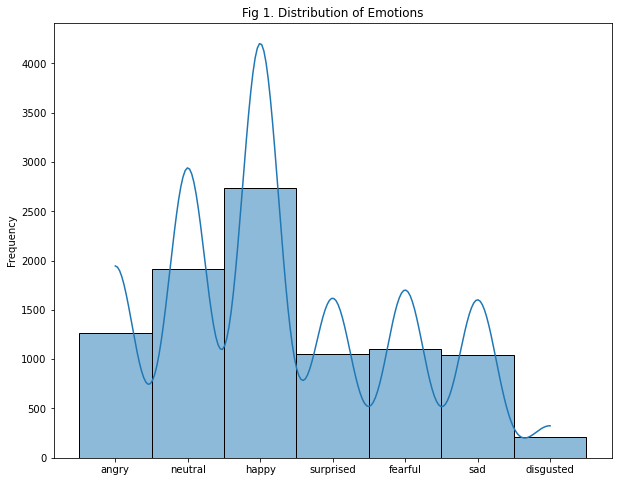

In [34]:
#Plotting the histogram for visualizing the distribution
f, ax = plt.subplots(figsize=(10, 8))
sns.histplot(emotions, kde=True)
plt.title("Fig 1. Distribution of Emotions")
plt.ylabel("Frequency")
plt.show()

` In Fig 1, We can clearly see that our dataset has class imbalance for emotions. Our models are not going to generalize well; especially for disgusted emotion. Compared to happy emotion it has almost 13 times lesser data. To overcome class imbalance problem we either need to drop this emotion or fetch more data for the emotions having less samples or we can also use data augmentation to generate data for less frequently occuring emotions. We can also merge this emotion with other emotions like sad or angry. Although our data is unbalanced, it is evenly distributed among the other sets`


# 2 Conventional ML Model

Now we will be experimenting with different algorithms and tecniques to examine which Conventional ML Model is working best on our dataset. Let's preprocess the data and start training. We will be using basic accuracy score metric and then plotting confusion matrix for the best performing model.

## 2.1 Data Preprocessing

In [35]:
print("Dimensions of the training features: ", images_train.ndim)
print("Dimensions of the training features: ", images_test_public.ndim)
print("(Height, Width, Depth): ", images_train.shape)

Dimensions of the training features:  3
Dimensions of the training features:  3
(Height, Width, Depth):  (9328, 48, 48)


Since training dataset is 3 dimensional, converting it to 2 dimensional array in which first dimension is maintained and the other two dimensions are flattened (so 48x48 becomes 2304). It Returns a copy of the array collapsed into one dimension.

Code for flattening can be found [here](https://stackoverflow.com/questions/34972142/sklearn-logistic-regression-valueerror-found-array-with-dim-3-estimator-expec)

In [36]:
#Flattening features of training set
nsamples, nx, ny = images_train.shape
images_train_2d = images_train.reshape((nsamples,nx*ny))

In [37]:
#Flattening features of public test set
nsamples, nx, ny = images_test_public.shape
images_test_public_2d = images_test_public.reshape((nsamples,nx*ny))

In [38]:
#Flattening features of private test set
nsamples, nx, ny = images_test_private.shape                           
images_test_private_2d = images_test_private.reshape((nsamples,nx*ny))

In [39]:
print("After Flattening the shape of array\n")
print("Dimensions of the training set features: ", images_train_2d.ndim)
print("Dimensions of the testing set features(PUBLIC): ", images_test_public_2d.ndim)
print("Dimensions of the testing set features(PUBLIC): ", images_test_private_2d.ndim)
print("Height, Width, Depth = ", images_train_2d.shape)

After Flattening the shape of array

Dimensions of the training set features:  2
Dimensions of the testing set features(PUBLIC):  2
Dimensions of the testing set features(PUBLIC):  2
Height, Width, Depth =  (9328, 2304)


## 2.2 Data Splitting & Feature Scaling
Our Dataset is ready for Modeling, Let's train some models and anlayse how each of them perform. In the next stag, we will be Splitting the data into training and testing sets with 80% traning set and 20% test set(for tunning models). we will be keeping RANDOM_STATE=42 throughout our experiments to keep the dataset distribution same for all the models and it will also allow us to reproduce the results. 

Please Note: It is a good practice to fine tune models on test set and then train on full dataset. However we will be using 80 percent data for training all the models as we are concerned with comparing different models on the same distribution of dataset within this notebook. We are not using 100% of the provided dataset. Using which can further improve the accuracy on Public and Private sets.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(images_train_2d, labels_train, test_size=0.2, random_state=42) 

In [41]:
print("Actual Training Sample Size: ", X_train.shape[0])
print("Actual Testing Sample Size: ", X_test.shape[0])

Actual Training Sample Size:  7462
Actual Testing Sample Size:  1866


Implemented the models with and without scaling features. Model's accuracy improved after scaling. Therefore, we are scaling the features.

In [42]:
#Normalising the features by fitting on the training set and then scaling other features using same fit. Results of standardscalar appeared to be the same using pipeline. 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
images_test_public_2d = sc.transform(images_test_public_2d)
images_test_private_2d = sc.transform(images_test_private_2d)

## 2.3 Conv Model Training: Main Dataset

### 2.3.1 Model 1: Linear SVC

In [43]:
#initialize 
LinearSVC_Classifier =  LinearSVC(max_iter = 10000,
                                  dual= True,
                                  verbose=1)

# Training the model
LinearSVC_Classifier.fit(X_train,y_train)

# Predicting Emotions on test set
y_test_predicted=LinearSVC_Classifier.predict(X_test)
print("Model accuracy for SVC:", accuracy_score(y_test,y_test_predicted)*100)

[LibLinear]Model accuracy for SVC: 40.728831725616296


/Users/bisarhasan/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### 2.3.2 Model 2: Random Forest Classifier

In [44]:
#initialize 
rf_Classifier =  RandomForestClassifier(n_estimators=500,
                                        random_state=42)

# Training the model
rf_Classifier.fit(X_train,y_train)

# Predicting Emotions on test set
y_test_predicted=rf_Classifier.predict(X_test)
print("Model accuracy for RFC:", accuracy_score(y_test,y_test_predicted)*100)

Model accuracy for RFC: 55.2518756698821


### 2.3.3 Model 3: Linear Gradient Bossting Machine(LGBM)

In [45]:
# Initialize Light Gradient Boosting Machine
lgbm_classifier = lgb.LGBMClassifier(learning_rate=0.1,
                                     max_depth =-1,
                                     min_child_samples=20,
                                     n_estimators=300)

# Training the model
lgbm_classifier.fit(X_train, y_train)

# Predicting Emotions on test set
y_pred = lgbm_classifier.predict(X_test)

# Calculate accuracy of the model
print("Model accuracy for LGBM:", accuracy_score(y_test,y_pred)*100)

Model accuracy for LGBM: 58.467309753483384


In [46]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(lgbm_classifier.get_params())

Parameters currently in use:

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 300, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


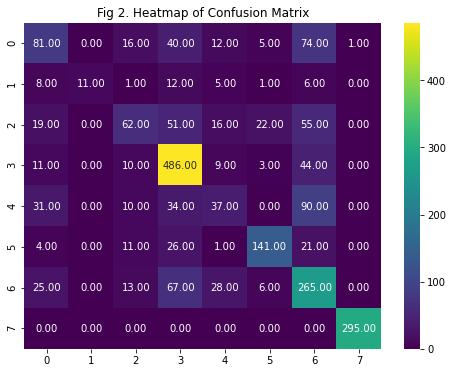

In [74]:
# Plot confusion matrix using seaborn instance
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='.2f', 
                                cmap = 'viridis')
plt.title("Fig 2. Heatmap of Confusion Matrix")
plt.show()

### 2.3.4 Predictions using Selected model(LGBM)

We have selected Light Gradient Boosting Machine as it outperformed all the other models in terms of accuracy. 

Now, we will be performing some predictions over the provided public test and private test sets and uploading the results to Kaggle for observing how accurately the selected model is performing on the unseen datasets.

#### 2.3.4.1 Prediction on Facial Expression Recognition: PUBLIC TEST


In [48]:
# Running the model on Public Test Set
public_test_predicted=lgbm_classifier.predict(images_test_public_2d)

In [52]:
# Generating PUBLIC test CSV
f = open(join(output_directory, '46335706_conv_predictions_lgbm_public.csv'), 'w')
f.write('ID,Predictions\n')
for i in range(len(public_test_predicted)):
  f.write(str(i) + f',{public_test_predicted[i]}\n')
f.close()

#### 2.3.4.2 Prediction on Facial Expression Recognition: PRIVATE TEST

In [53]:
# Running the model on Priavate Test Set
private_test_predicted=lgbm_classifier.predict(images_test_private_2d)

In [54]:
# Generating PRIVATE test CSV
f = open(join(output_directory, '46335706_conv_predictions_lgbm_private.csv'), 'w')
f.write('ID,Predictions\n')
for i in range(len(private_test_predicted)):
  f.write(str(i) + f',{private_test_predicted[i]}\n')
f.close()

## 2.4 Conv Model Training: Out-of-Domain Dataset

Now we are going to implement the same selected model(LGBM) on the combination of main(subset of FER) dataset and out-of-domain MNIST dataset from the MNIST dataset. The main objective is to see if our selected models generalizes well on the the digits dataset along with the faces dataset. MNIST is a handwritten digits dataset which is populary used by beginners who are learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting as digits are centered and in acceptable quality.

### 2.4.1 OOD Data Preprocessing

In [56]:
#MNIST Dataset (Training features + Training Target variables)
images_train_mnist = np.load(join(dataset_directory, 'MNIST_dev_data_images.npy')) #MNIST features
labels_train_mnist = np.load(join(dataset_directory, 'MNIST_dev_data_labels.npy')) #MNIST outcome

PublicTest_faces_plus_data_images = np.load(join(dataset_directory, 'PublicTest_faces_plus_data_images.npy'))  
PrivateTest_faces_plus_data_images = np.load(join(dataset_directory, 'PrivateTest_faces_plus_data_images.npy'))

# images_train_mnist = images_train_mnist.reshape([-1, image_size, image_size]) #Reshaping MNIST
# PublicTest_faces_plus_data_images = PublicTest_faces_plus_data_images.reshape([-1, image_size, image_size]) #facespublic
# PrivateTest_faces_plus_data_images = PublicTest_faces_plus_data_images.reshape([-1, image_size, image_size]) #facesprivate

print("MNIST other emotions(7) count added: ",  images_train_mnist.shape[0])

#Reshape MNIST lable
labels_train_mnist_Transposed = labels_train_mnist.T #Transposing the row as column
labels_train_mnist_Flattened = labels_train_mnist_Transposed.flatten() #Flattening 2 dimensional array into 1 dimensional array

MNIST other emotions(7) count added:  1500


> Since the classes in MNIST dataset are numbers and in our case we determine all the numbers as OTHERS(7th) category while predicting Facial Emotion Recoginition. Hence we are changing the labels of all the MNIST samples to 7.

In [57]:
labels_train_mnist_updated = labels_train_mnist_Flattened.copy()
for i in range(len(labels_train_mnist_updated)):
    labels_train_mnist_updated[i] = 7
print("Labels Updated: ", labels_train_mnist_updated)

Labels Updated:  [7 7 7 ... 7 7 7]


In [105]:
#Concatenate Faces train features and MNIST train features
images_train_combined = np.concatenate((images_train, images_train_mnist), axis=0)
#Concatenate Faces train labels and MNIST train labels
labels_train_combined = np.concatenate((labels_train, labels_train_mnist_updated), axis=0)

In [59]:
print("features from private test set: ", images_train_combined.shape)

features from private test set:  (10828, 48, 48)


In [60]:
print("Dimensions of the Combined training set features: ", images_train_combined.ndim)
print("Dimensions of the PublicTest Faces Plus data features: ", PublicTest_faces_plus_data_images.ndim)
print("Dimensions of the PrivateTest Faces Plus data features: ", PrivateTest_faces_plus_data_images.ndim)

Dimensions of the Combined training set features:  3
Dimensions of the PublicTest Faces Plus data features:  3
Dimensions of the PrivateTest Faces Plus data features:  3


In [61]:
# Again we are converting 3 dimensional 2 dimesional array.
nsamples, nx, ny = images_train_combined.shape
images_train_combined_2d = images_train_combined.reshape((nsamples,nx*ny))

In [62]:
# Flattening features of public test set
nsamples, nx, ny = PublicTest_faces_plus_data_images.shape
PublicTest_faces_plus_data_images_2d = PublicTest_faces_plus_data_images.reshape((nsamples,nx*ny))

In [63]:
# Flattening features of private test set
nsamples, nx, ny = PrivateTest_faces_plus_data_images.shape
PrivateTest_faces_plus_data_images_2d = PrivateTest_faces_plus_data_images.reshape((nsamples,nx*ny))

In [64]:
print("After Flattening the shape of array\n")
print("Dimensions of the Combined training set features: ", images_train_combined_2d.ndim)
print("Dimensions of the PublicTest Faces Plus data features: ", PublicTest_faces_plus_data_images_2d.ndim)
print("Dimensions of the PrivateTest Faces Plus data features: ", PrivateTest_faces_plus_data_images_2d.ndim)

After Flattening the shape of array

Dimensions of the Combined training set features:  2
Dimensions of the PublicTest Faces Plus data features:  2
Dimensions of the PrivateTest Faces Plus data features:  2


### 2.4.2 Splitting Combined Dataset

Distribution of split will change for this dataset as we have added new samples from MNIST dataset to the main dataset. However, same distribution will still be used for conv and deep learning model as we are still splitting using random_state = 42.

In [65]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images_train_combined_2d, labels_train_combined, test_size=0.2, random_state=42)

In [66]:
#fittin
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
PublicTest_faces_plus_data_images_2d = sc.transform(PublicTest_faces_plus_data_images_2d)
PrivateTest_faces_plus_data_images_2d = sc.transform(PrivateTest_faces_plus_data_images_2d)

### 2.4.3 Fitting Selected Model(LGBM) on Combined Dataset

In [67]:
# Initialize Light Gradient Boosting Machine
lgbm_classifier = lgb.LGBMClassifier(learning_rate=0.1,
                                     n_estimators=300)

# Fitting the model on the train data and training it
lgbm_classifier.fit(X_train, y_train)

# Predict on test data
y_pred = lgbm_classifier.predict(X_test)

# Calculate accuracy of the model
print("Model accuracy for LGBM:", accuracy_score(y_test,y_pred)*100)

Model accuracy for LGBM: 63.61957525392429


### 2.4.4 Predictions on OOD using Selected model

#### 2.4.4.1 Prediction on Facial Expression Recognition (OOD): PUBLIC TEST

In [68]:
#Running the model on Public Test Set
Public_faces_test_predicted=lgbm_classifier.predict(PublicTest_faces_plus_data_images_2d)

In [69]:
#Generating PUBLIC test CSV
f = open(join(output_directory, '46335706_conv_predictions_lgbm_MNIST_PUBLIC.csv'), 'w')  
f.write('ID,Predictions\n')
for i in range(len(Public_faces_test_predicted)):
  f.write(str(i) + f',{Public_faces_test_predicted[i]}\n')
f.close()

#### 2.4.4.2 Prediction on Facial Expression Recognition (OOD): PRIVATE TEST

In [70]:
#Running the model on Private Test Set
Private_faces_test_predicted=lgbm_classifier.predict(PrivateTest_faces_plus_data_images_2d)

In [73]:
#Generating PRIVATE test CSV
f = open(join(output_directory, '46335706_conv_predictions_lgbm_MNIST_PRIVATE.csv'), 'w')
f.write('ID,Predictions\n')
for i in range(len(Private_faces_test_predicted)):
  f.write(str(i) + f',{Private_faces_test_predicted[i]}\n')
f.close()

## 2.5 Notes on the Conventional ML Model

In this notebook, We have mainly experimented 3 models: Linear Support Vector Machine, Random Forest Classifier and Light Gradient Boosting Machine. The final model that produced the best-performing predictions on test sets is LGBM with accuracy 57.66% while RFC was on the second number with accuracy 55.25% and the lastly Linear SVC with accuracy 40.72 %. I have futher implemented KNN and other practices like RandomizedSearchCV for RFC and LGBM to evaluate best parameters. However, for the sake of keeping this notebook clean and easy to evaluate, I have removed all the extra code. 
***

**Selected Model:**
`We have selected LGBM as the best performing model, LGBM was giving best accuracy for the default parameters. It's accuracy slighlty inceased by 2% after increasing the n_estimators from 300 to 3000 but it took more than 10 times to execute the code. I also observed the results with and without feature normalization using standard scalar and normalizing the features gave a better accuracy than the actual feature array.`

# 3 Deep Learning Model

Now we will be experimenting with popular convolutional neural network alogorithm with multiple architechtures. Conventional ML Model is working best on our dataset. Let's preprocess the data and start training. We will be using evaluating model performance mainly on validation loss and accuracy. 

## 3.1 Data Preprocessing and splitting


In [119]:
# Data is already loaded in the first section of this notebook
# we are using imagery data. Since min = 0 and max = 255 for pixel data, so we are going to divide it by 255 for Normalizing the features (scaling the values)
#Training Data
images_train_3d = np.array(images_train,'float32')
images_train_3d -= np.mean(images_train_3d, axis=0)
images_train_3d /= np.std(images_train_3d, axis=0)
images_train_3d = images_train_3d.reshape(-1, 48, 48, 1)
images_train_3d = images_train_3d.astype("float") / 255.0 # Normalize image pixel values to be between 0 and 1

#Public Test Data
images_test_public_3d = np.array(images_test_public,'float32')
images_test_public_3d -= np.mean(images_test_public_3d, axis=0)
images_test_public_3d /= np.std(images_test_public_3d, axis=0)
images_test_public_3d = images_test_public_3d.reshape(-1, 48, 48, 1)
images_test_public_3d = images_test_public_3d.astype("float") / 255.0

#Private Test Data
images_test_private_3d = np.array(images_test_private,'float32')
images_test_private_3d -= np.mean(images_test_private_3d, axis=0)
images_test_private_3d /= np.std(images_test_private_3d, axis=0)
images_test_private_3d = images_test_private_3d.reshape(-1, 48, 48, 1)
images_test_private_3d = images_test_private_3d.astype("float") / 255.0


# Training Labels
num_labels = len(np.unique(labels_train))
labels_train_deep = np.array(labels_train,'float32')
labels_train_deep = np_utils.to_categorical(labels_train_deep, num_classes=num_labels)

In [120]:
# We are splitting and getting Same distribution as used for Conventional ML model
X_train, X_test, y_train, y_test = train_test_split(images_train_3d, labels_train_deep, test_size=0.2, random_state=42)

## 3.2 Deep Learning Models (CNN) on Main Dataset

### 3.2.1 Model 1: Basic Convolutional Neural Network Model

In [121]:
#defining parameters for reducing learning rate if loss is not decreasing and saving models to disk
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

mcp_save = ModelCheckpoint(
    '.mdl_wts.hdf5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max')

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    mcp_save,
    lr_scheduler,
]

In [122]:
keras.backend.clear_session()
tf.random.set_seed(42) #for reproduceability of the results using same models
np.random.seed(42)

# Initializing model object
model1 = Sequential()

# 1st Convolutional Layer
model1.add(Conv2D(64, (5,5), input_shape = (48, 48, 1)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolutional Layer
model1.add(Conv2D(128, (3,3)))
model1.add(Activation("relu"))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten Layer
model1.add(Flatten())

#Dense Layer
model1.add(Dense(64))
model1.add(Activation('relu'))

#Ouput Layer
model1.add(Dense(7))
model1.add(Activation('softmax'))

model1.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

history = model1.fit(X_train, y_train, batch_size=32, epochs=50, steps_per_epoch=len(X_train)/32, validation_data=(X_test, y_test), callbacks=callbacks, use_multiprocessing=True)

Epoch 1/50
233/233 [==============================] - 17s 69ms/step - loss: 1.7892 - accuracy: 0.2916 - val_loss: 1.7250 - val_accuracy: 0.3210 - lr: 0.0010
Epoch 2/50
233/233 [==============================] - 19s 80ms/step - loss: 1.6440 - accuracy: 0.3807 - val_loss: 1.5699 - val_accuracy: 0.4314 - lr: 0.0010
Epoch 3/50
233/233 [==============================] - 18s 78ms/step - loss: 1.5269 - accuracy: 0.4451 - val_loss: 1.4899 - val_accuracy: 0.4609 - lr: 0.0010
Epoch 4/50
233/233 [==============================] - 19s 84ms/step - loss: 1.4383 - accuracy: 0.4807 - val_loss: 1.4329 - val_accuracy: 0.4620 - lr: 0.0010
Epoch 5/50
233/233 [==============================] - 18s 76ms/step - loss: 1.3660 - accuracy: 0.5074 - val_loss: 1.3670 - val_accuracy: 0.4952 - lr: 0.0010
Epoch 6/50
233/233 [==============================] - 18s 78ms/step - loss: 1.3117 - accuracy: 0.5256 - val_loss: 1.3733 - val_accuracy: 0.4930 - lr: 0.0010
Epoch 7/50
233/233 [==============================] - 18s 

In [123]:
model1.evaluate(X_test, y_test)

59/59 [==============================] - 1s 15ms/step - loss: 1.8543 - accuracy: 0.5729


[1.854318618774414, 0.5728831887245178]

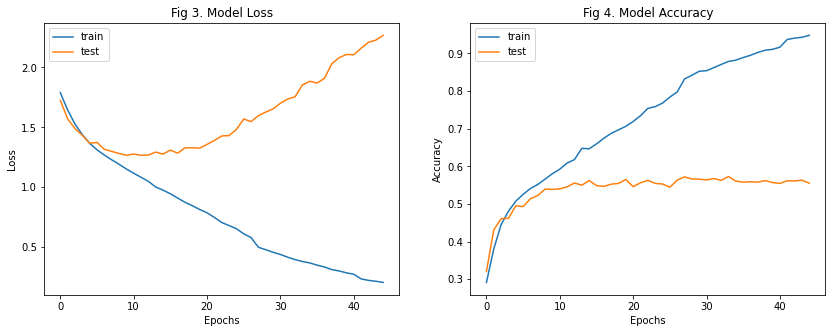

In [129]:
# Plotting train and validation loss and accuracies for above model
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Fig 3. Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Fig 4. Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


`In above figures we can clearly see that our Basic Convolutional Neural Network is overfitting as it is giving 99% accuracy on the training set while the accuracy of validation set doesnot improve after 59%. I have also tried used dropout() and regularization but it was making the accuracy stangnant. Let's use Random Search to try multiple conv_layers, dense_layers and filter sizes. After that we will be training on a complex architecture` 

### 3.2.2 Random Search (Training CNN on Different Combination of Layers and Parameters)

In [ ]:
# Commenting this as it is taking too much time to run again for final output
# dense_layers = [0,1,2]
# layer_sizes = [32,64,128]
# conv_layers = [1,2,3]

# import time


# for dense_layer in dense_layers:
#   for layer_size in layer_sizes:
#     for conv_layer in conv_layers:
#       print("{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time())))
#       model = Sequential()

#       # 1 - Convolution
#       model.add(Conv2D(layer_size, (3,3), input_shape = (48, 48, 1)))
#       model.add(Activation('relu'))
#       model.add(MaxPooling2D(pool_size=(2, 2)))

#       for l in range(conv_layer-1):
#         model.add(Conv2D(layer_size, (3,3)))
#         model.add(Activation("relu"))
#         model.add(MaxPooling2D(pool_size=(2, 2)))

#       model.add(Flatten()) #  this converts our 3D feature maps to 1D feature vectors
#       for l in range(dense_layer):
#         model.add(Dense(layer_size))
#         model.add(Activation("relu"))

#       model.add(Dense(7))
#       model.add(Activation('softmax'))

#       model.compile(loss="categorical_crossentropy",
#                     optimizer="adam",
#                     metrics=['accuracy'])

#       model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

### 3.2.3 Model 2: Selecting more complicated Conv2D Architecture (6 Layer)

Our Accuracy didn't improve. Hence we are using this [architecture](https://www.kaggle.com/code/gauravsharma99/facial-emotion-recognition/notebook) to see if our model is imroving in terms of accuracy.

In [83]:
model2 = Sequential()

# 1st Convolutional Layer
model2.add(Conv2D(filters=64, kernel_size=(5,5), input_shape=(48, 48, 1), activation='elu', padding='same'))
model2.add(BatchNormalization())

# 2nd Convolutional Layer
model2.add(Conv2D(filters=64, kernel_size=(5,5), activation='elu', padding='same', kernel_initializer='he_normal'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.4))

# 3rd Convolutional Layer
model2.add(Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
model2.add(BatchNormalization())

# 4th Convolutional Layer
model2.add(Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
model2.add(BatchNormalization())    
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.4))

# 5th Convolutional Layer
model2.add(Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same',kernel_initializer='he_normal'))
model2.add(BatchNormalization())

# 6th Convolutional Layer
model2.add(Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.5))          
          
# Flatten Layer
model2.add(Flatten())

# Fully Connected Dense Layer      
model2.add(Dense(128, activation='elu', kernel_initializer='he_normal'))
model2.add(BatchNormalization())
model2.add(Dropout(0.6))
          
#Ouput Layer          
model2.add(Dense(7, activation='softmax')) #changing it to
          
#Compilation of model          
model2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# please change epochs=100 or 1000
model2.fit(X_train, y_train, batch_size=32, epochs=10, steps_per_epoch=len(X_train)/32, validation_data=(X_test, y_test), callbacks=callbacks, use_multiprocessing=True)

Epoch 1/10
233/233 [==============================] - 187s 796ms/step - loss: 2.2460 - accuracy: 0.3066 - val_loss: 3.1318 - val_accuracy: 0.2020 - lr: 0.0010
Epoch 2/10
233/233 [==============================] - 211s 906ms/step - loss: 1.5841 - accuracy: 0.4412 - val_loss: 2.4479 - val_accuracy: 0.2513 - lr: 0.0010
Epoch 3/10
233/233 [==============================] - 192s 820ms/step - loss: 1.3808 - accuracy: 0.4973 - val_loss: 1.3512 - val_accuracy: 0.5166 - lr: 0.0010
Epoch 4/10
233/233 [==============================] - 190s 816ms/step - loss: 1.2797 - accuracy: 0.5421 - val_loss: 1.3700 - val_accuracy: 0.5064 - lr: 0.0010
Epoch 5/10
233/233 [==============================] - 194s 832ms/step - loss: 1.2217 - accuracy: 0.5528 - val_loss: 1.3190 - val_accuracy: 0.5188 - lr: 0.0010
Epoch 6/10
233/233 [==============================] - 199s 852ms/step - loss: 1.1607 - accuracy: 0.5717 - val_loss: 1.6369 - val_accuracy: 0.4469 - lr: 0.0010
Epoch 7/10
233/233 [==========================

In [84]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization_7 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                      

In [85]:
model2.save(join(dataset_directory , "deep-CNN-Conv2d-6Layers.h5"))
#model2.load_weights(join(dataset_directory , "deep-CNN-Conv2d-6Layers.h5")) #use this to reload the model

### 3.2.4 Predictions using Selected Model(Model 2: 6 Layer)

#### 3.2.4.1 Prediction on Facial Expression Recognition: PUBLIC Test

In [86]:
# Running the conv 6 Layer model2 on Public Test Set
Public_test_predicted_deep = model2.predict(images_test_public_3d)
Public_test_predicted_deep = list(np.argmax(Public_test_predicted_deep,axis=1))

36/36 [==============================] - 7s 200ms/step


In [87]:
# Generate PUBLIC test CSV
f = open(join(dataset_directory, '46335706_deep_predictions_conv2d_6Layer.csv'), 'w') 
f.write('ID,Predictions\n')
for i in range(len(Public_test_predicted_deep)):
  f.write(str(i) + f',{Public_test_predicted_deep[i]}\n')
f.close()

#### 3.2.4.2 Prediction on Facial Expression Recognition: PRIAVET Test

In [89]:
# Running the model on Public Test Set
Private_test_predicted_deep = model2.predict(images_test_private_3d)
Private_test_predicted_deep = list(np.argmax(Private_test_predicted_deep,axis=1))

37/37 [==============================] - 6s 167ms/step


In [90]:
# Generate PUBLIC test CSV
f = open(join(dataset_directory, '46335706_deep_predictions_conv2d_6Layer_PRIVATE.csv'), 'w')  ## FOR EXAMPLE
f.write('ID,Predictions\n')
for i in range(len(Private_test_predicted_deep)):
  f.write(str(i) + f',{Private_test_predicted_deep[i]}\n')  ## REPLACE THE ZERO WITH YOUR PREDICTION FOR THAT IMAGE
f.close()

In [91]:
model2.evaluate(X_test, y_test)

59/59 [==============================] - 11s 194ms/step - loss: 1.3851 - accuracy: 0.4909


[1.3851011991500854, 0.49088960886001587]

## 3.3 Deep Learning Models (CNN): Out-of-Domain Dataset

### 3.3.1 OOD Data Preprocessing

In [109]:
# Training Data
images_train_combined_3d = np.array(images_train_combined,'float32')
images_train_combined_3d -= np.mean(images_train_combined_3d, axis=0)
images_train_combined_3d /= np.std(images_train_combined_3d, axis=0)
images_train_combined_3d = images_train_combined_3d.reshape(-1, 48, 48, 1)
images_train_combined_3d = images_train_combined_3d.astype("float") / 255.0

#Public Test Data
PublicTest_faces_plus_data_images_3d = np.array(PublicTest_faces_plus_data_images,'float32')
PublicTest_faces_plus_data_images_3d -= np.mean(PublicTest_faces_plus_data_images_3d, axis=0)
PublicTest_faces_plus_data_images_3d /= np.std(PublicTest_faces_plus_data_images_3d, axis=0)
PublicTest_faces_plus_data_images_3d = PublicTest_faces_plus_data_images_3d.reshape(-1, 48, 48, 1)
PublicTest_faces_plus_data_images_3d = PublicTest_faces_plus_data_images_3d.astype("float") / 255.0

#Private Test Data
PrivateTest_faces_plus_data_images_3d = np.array(PrivateTest_faces_plus_data_images,'float32')
PrivateTest_faces_plus_data_images_3d -= np.mean(PrivateTest_faces_plus_data_images_3d, axis=0)
PrivateTest_faces_plus_data_images_3d /= np.std(PrivateTest_faces_plus_data_images_3d, axis=0)
PrivateTest_faces_plus_data_images_3d = PrivateTest_faces_plus_data_images_3d.reshape(-1, 48, 48, 1)
PrivateTest_faces_plus_data_images_3d = PrivateTest_faces_plus_data_images_3d.astype("float") / 255.0


# Training Labels
num_labels = len(np.unique(labels_train_combined))
labels_train_combined_deep = np.array(labels_train_combined,'float32')
labels_train_combined_deep = np_utils.to_categorical(labels_train_combined_deep, num_classes=num_labels)

### 3.3.2 Splitting Combined Dataset

In [110]:
X_train, X_test, y_train, y_test = train_test_split(images_train_combined_3d, MNIST_images_labels, test_size=0.2, random_state=42)

### 3.3.3 Fitting Selected Model(6 Layer) on Combined Dataset

In [111]:
model_MNIST = Sequential()

# 1st Convolutional Layer
model_MNIST.add(Conv2D(filters=64, kernel_size=(5,5), input_shape=(48, 48, 1), activation='elu', padding='same'))
model_MNIST.add(BatchNormalization())

# 2nd Convolutional Layer
model_MNIST.add(Conv2D(filters=64, kernel_size=(5,5), activation='elu', padding='same', kernel_initializer='he_normal'))
model_MNIST.add(BatchNormalization())
model_MNIST.add(MaxPooling2D(pool_size=(2, 2)))
model_MNIST.add(Dropout(0.4))

# 3rd Convolutional Layer
model_MNIST.add(Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
model_MNIST.add(BatchNormalization())

# 4th Convolutional Layer
model_MNIST.add(Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
model_MNIST.add(BatchNormalization())    
model_MNIST.add(MaxPooling2D(pool_size=(2, 2)))
model_MNIST.add(Dropout(0.4))

# 5th Convolutional Layer
model_MNIST.add(Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same',kernel_initializer='he_normal'))
model_MNIST.add(BatchNormalization())

# 6th Convolutional Layer
model_MNIST.add(Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
model_MNIST.add(BatchNormalization())
model_MNIST.add(MaxPooling2D(pool_size=(2, 2)))
model_MNIST.add(Dropout(0.5))          
          
# Flatten Layer
model_MNIST.add(Flatten())

# Fully Connected Dense Layer      
model_MNIST.add(Dense(128, activation='elu', kernel_initializer='he_normal'))
model_MNIST.add(BatchNormalization())
model_MNIST.add(Dropout(0.6))
          
#Ouput Layer          
model_MNIST.add(Dense(8, activation='softmax')) #changing it to 8
          
#Compilation of model          
model_MNIST.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# please change epochs=100 or 1000
model_MNIST.fit(X_train, y_train, batch_size=32, epochs=2, steps_per_epoch=len(X_train)/32, validation_data=(X_test, y_test), callbacks=callbacks, use_multiprocessing=True)

Epoch 1/2
270/270 [==============================] - 235s 865ms/step - loss: 1.6805 - accuracy: 0.4338 - val_loss: 3.5207 - val_accuracy: 0.1865 - lr: 0.0010
Epoch 2/2
270/270 [==============================] - 205s 758ms/step - loss: 1.2977 - accuracy: 0.5316 - val_loss: 1.7597 - val_accuracy: 0.3689 - lr: 0.0010


In [112]:
model_MNIST.save(join(dataset_directory , "deep-CNN-Conv2d-6Layers-MNIST.h5"))

In [113]:
model_MNIST.evaluate(X_test, y_test)

68/68 [==============================] - 14s 203ms/step - loss: 1.7597 - accuracy: 0.3689


[1.759748935699463, 0.3688827455043793]

### 3.3.4 Predictions on OOD using 6 Layer Model

#### 3.4.4.1 Prediction of Facial Expression Recognition (OOD): PUBLIC Test

In [114]:
# Running the model on Public Test Set
Public_faces_test_predicted_deep = model_MNIST.predict(PublicTest_faces_plus_data_images_3d)
Public_faces_test_predicted_deep =  list(np.argmax(Public_faces_test_predicted_deep,axis=1))

52/52 [==============================] - 10s 194ms/step


In [115]:
# Generate PUBLIC test CSV

f = open(join(ouput_directory, '46335706_deep_predictions_conv2d_6Layer_MNIST_PUBLIC.csv'), 'w')
f.write('ID,Predictions\n')
for i in range(len(Public_faces_test_predicted_deep)):
  f.write(str(i) + f',{Public_faces_test_predicted_deep[i]}\n')
f.close()

#### 3.4.4.2 Prediction of Facial Expression Recognition (OOD): PRIVATE Test

In [8]:
# Running the model on Public Test Set
Private_faces_test_predicted_deep = model_MNIST.predict(PrivateTest_faces_plus_data_images_3d)
Private_faces_test_predicted_deep =  list(np.argmax(Private_faces_test_predicted_deep,axis=1))

In [16]:
# Generate PRIVATE test CSV
f = open(join(output_directory, '46335706_deep_predictions_conv2d_6Layer_MNIST_PRIVATE.csv'), 'w')
f.write('ID,Predictions\n')
for i in range(len(private_faces_test_Predicted_deep)):
  f.write(str(i) + f',{private_faces_test_Predicted_deep[i]}\n')
f.close()

## 3.4 Notes on Deep Learning Models (CNN) on Main Dataset and ODD

We have trained one basic and one complex convolutional neural networks. We have used early stopping and ReduceLROnPlateau. These methods can help us for reducing the learning rate if model performance is not improving and for avoiding overfitting. We have used model checkpoint to save weights of neurons on a specific epoch. Futhermore, tensorboard can be used to see model performance for diffent metrics which can asssist for fine-tuning the models.

***
**Model 1:** 2 Convolution layers, 1 Flatten Layer, 1 Dense Layer and 1 output layer. We have used "relu" as activation function. I have tried dropout and L1 L2 regularization but it was not working so it was removed. Model was badly overfitting and the possible reason could be that the model has a high variance or the size of the training dataset used is not enough or the model doesn't have a reliable architecture for this problem. 

***
**Model 2(6 Layers):** 6 Convolution layers, 1 Flatten Layer, 1 Dense Layer and 1 output layer. To cater dying relu problem, this time we have tried "elu" as an activation function. We have also used loss function as Adam(learning_rate=0.001) this time. Accuracy for model 2 with 6 layers went up to 70 on 45 epochs. Running more Epochs with different parameters can further improve the results. Our second DL model had:

Total params: 2,395,591</br>
Trainable params: 2,393,543</br>
Non-trainable params: 2,048</br>

We have used filters of 62 in first two, 128 in 3rd & 4th and 256 in last two convolutional layers along with Dropouts of 40% neurons. We have also used BatchNormalization and MaxPooling 2D. We can also test Average Pooling and other activation functions to observe their results. 

And at 45th Epoch it had a validation accuracy of 70%

Epoch 45/70
270/270 [==============================] - 191s 704ms/step - loss: 0.0670 - accuracy: 0.9793 - val_loss: 1.4907 - val_accuracy: 0.7018 - lr: 2.5000e-04
***
**Selected Model:**
`We have selected Model 2(6 Layers) as it's accuracy has significantly imrpoved to 70% from 59% and it has further potential to improve by tunning parameters.`

# 4 Discussion of Model Performance and Implementation

This Kernal implemented conventional(LGBM) and deep learning models usind Keras + Tensorflow CNN for the Facial Expression Recognition competition. It has yielded results of 64.26% on the leaderboard. With some more tuning, data augmentation, including more samples to the dataset and Transfer Learning(using pretrained models) a better result could be yielded.


**Facial Expression Recognition(PUBLIC):**

Conventional - LGBM : 0.57

Deep Learning - CNN Model 2(6 Layer) : 0.64

**Facial Expression Recognition(PRIVATE):**

Conventional - LGBM : 0.60

Deep Learning - CNN Model 2(6 Layer) : 0.67

**Accuracy improved by 7 percent for Deep Learning Model comparing to conventional learning model. Moreover, accuracies improved by 2-3% on the private sets comparing to public sets. Above tread off shows that both the techniques produced are producing generalised models.**

***

**Facial Expression Recognition OOD (PUBLIC):**

Conventional - LGBM : 0.70

Deep Learning - CNN Model 2(6 Layer) : 0.74

**Facial Expression Recognition OOD (PRIVATE):**

Conventional - LGBM : 0.55

Deep Learning - CNN Model 2(6 Layer) : 0.19

**Accuracies on the OOD dataset was improved by 13% for the conventional model and 7% for the DL Model.**
***
**Conclusion:**

`We have used smaller subset of FER dataset having class imbalance and tested mutiple conventional and deep learning models out of which Light Gradient Boosting Machine performed the best in convential and Conv2d with 6 Layers even outperformed the convential model by improving the accuracy by 7%. We have also fitted models on out of domain datasets and our model was able to generalize other patterns(digits) as well along with faces. We can further improve accuracies by simply reducing the class imbalance and by also including more data. We can also use ResNets and Inception V3 to explore their results. Lastly, Transfer learning using pretrained models can drastically train a high-performing model. Future work can be done by integrating the trained models with webcam and use for security or other purposes.`